# # Simple Convolutional Neural Network with Pytorch


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),        # Converts to tensor, scales 0–255 → 0–1
    transforms.Normalize((0.5,), (0.5,))  # Normalize grayscale images
])

train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 342kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.20MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.27MB/s]


In [4]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)

        self.fc1 = nn.Linear(64 * 5 * 5, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))    # Output: [batch, 32, 26, 26]
        x = self.pool(x)             # Output: [batch, 32, 13, 13]

        x = F.relu(self.conv2(x))    # Output: [batch, 64, 11, 11]
        x = self.pool(x)             # Output: [batch, 64, 5, 5]

        x = x.view(-1, 64 * 5 * 5)   # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN().to(device)
print(model)

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
epochs = 10
for epoch in range(epochs):
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Training completed!")

Epoch [1/10], Loss: 0.1731
Epoch [2/10], Loss: 0.0508
Epoch [3/10], Loss: 0.0350
Epoch [4/10], Loss: 0.0263
Epoch [5/10], Loss: 0.0211
Epoch [6/10], Loss: 0.0162
Epoch [7/10], Loss: 0.0125
Epoch [8/10], Loss: 0.0114
Epoch [9/10], Loss: 0.0083
Epoch [10/10], Loss: 0.0084
Training completed!


In [7]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"\nTest Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 99.01%


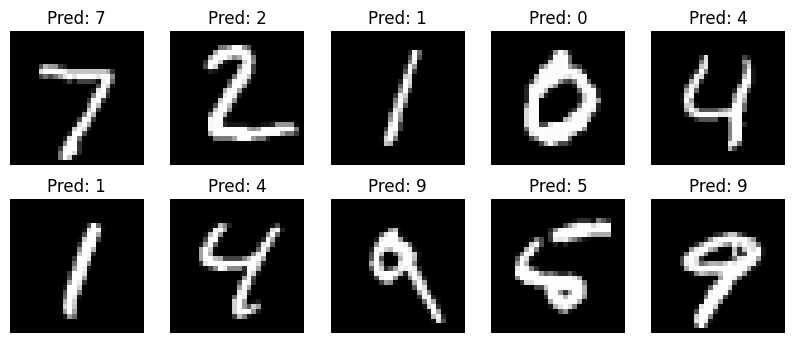

In [8]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

example_data = example_data.to(device)
output = model(example_data)

plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    img = example_data[i].cpu().squeeze()
    plt.imshow(img, cmap='gray')
    pred = output[i].argmax().item()
    plt.title(f"Pred: {pred}")
    plt.axis('off')

plt.show()

In [9]:
torch.save(model.state_dict(), "mnist_cnn.pth")

#Predict on a new image

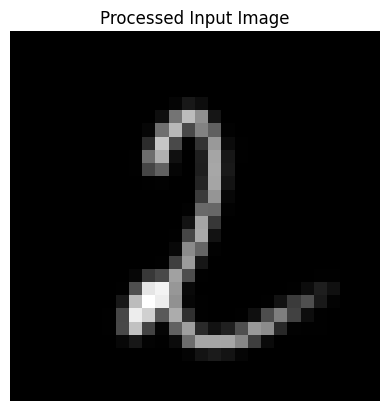

Predicted Digit: 2


2

In [28]:
from PIL import Image

model = SimpleCNN()                # same class you defined earlier
model.load_state_dict(torch.load("mnist_cnn.pth", map_location="cpu"))
model.eval()

transform = transforms.Compose([
    transforms.Grayscale(),                 # convert to 1 channel
    transforms.Resize((28, 28)),            # resize to MNIST size
    transforms.ToTensor(),                  # convert to tensor (0–1)
    transforms.Lambda(lambda x: 1 - x)      # invert colors if needed
])


def predict_external_image(model, img_path):
    # Load image with PIL
    img = Image.open(img_path)

    # Apply MNIST transforms
    img_tensor = transform(img)

    # Add a batch dimension: (1, 1, 28, 28)
    img_tensor = img_tensor.unsqueeze(0)

    # Show the processed image
    plt.imshow(img_tensor.squeeze().numpy(), cmap="gray")
    plt.title("Processed Input Image")
    plt.axis("off")
    plt.show()

    # Forward pass through model
    with torch.no_grad():
        output = model(img_tensor)

    # Get predicted class
    predicted_label = torch.argmax(output, dim=1).item()
    print("Predicted Digit:", predicted_label)
    return predicted_label


predict_external_image(model, "002.png")